- Authors: Ray Donner and Seth Johnson
- Date: May 25, 2023
- Content: This file is a conglomerate of all the machine learning algorithms that we run and collect data on. This will include the following algorithms:
    - Categorical Naive-Bayes
    - Support Vector Machines
    - Decision Trees
    - Neural Network
    - Convolutional Neural Network
- The goal is to analyze this with our new dataset COVID19_APK_Data_06-2023.csv and compare train/test performace, as well as provide statistical analysis to compare COVIDMalware.pdf dataset to ours.

For Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/2023_REU_Workspace

print(os.getcwd())

RUN ME FIRST

In [1]:
### Package Handling
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import pylab as pl
import random
from pprint import pprint

### Static Variable Declaration
# !!! CHANGE THESE VALUES IF WE WANT TO TWEAK OUR MODELS !!!!
FOLDS = 5 # How many times our models will iterate through a dataset
RANDOM_STATE = 42 # The entropy of our paritioned datasets. This determines how similar one dataset is to the next.
TEST_SIZE = 0.2 # The percentage of testing data to the training data. 
CSV_FILE = "COVID19_APK_Data_06-2023.csv" # CSV File consisting of analyzed APK data

### Variable Declaration
# CSV reference
apkData = -1 # DataFrame of all APK data harvested from APKScanner.py
apks = -1 # NumPy array that lists apk file hashes
avRanks = -1 # NumPy Array that lists the AV Ranking for each file
# Reference arrays
keys = [] # Lables of CSV data that is NOT the permissions requested by a given APK file
permKeys = [] # Key values for the permissions requested by a given APK file. This is for reference for our perms array
osPermKeys = [] # Key values for all permissions associated with the base AndroidOS devkit
# Separating permission spreads between benign and malicious apk tyes
permSpread = [] # Array of arrays representing the permissions that a given apk file requests
osPermSpread = [] # Array of arrays representing permission spread of all apk base AndroidOS requests
benignSpread = [] # Array of arrays that represent all permissions that a benign APK file requests
maliciousSpread = [] # Array of arrays that represent all permissions that a malicious APK file requests
benignSpread_OS = [] # Array of arrays representing all AndroidOS permissions that a benign APK file requests
maliciousSpread_OS = [] # Array of arrays representing all AndroidOS permissions that a malicious APK file requests
benignSpread_sums = [] # Array representing the total sum of all permissions a given benign apk file requests
maliciousSpread_sums = [] # Array represnting total sum of all permissions a given malicious apk file requests
benignPerms = [] # Array representing how many times a benign APK file requests a given permission. The index of each value represents how many times a permission in permSpread is requested.
maliciousPerms = [] # Array representing how many times a malicious APK file requests a given permission. The index of each value represents how many times a permission in permSpread is requested.
benignPerms_OS = [] # Array representing how many times a benign APK file requests a given AndroidOS permission
maliciousPerms_OS = [] # Array representing how many times a malicious APK file requests a given AndroidOS permission
# for our models
perms = -1 # "Features". NumPy array consisting of arrays which hold the permission attributes for a given element in apks @ the same index. First two elements indicate AV Rank, and Total Permissions Requested. Subsequent elements are a binary representation of the types of permissions the apk file requests.
labels = [] # "Labels". Array of arrays of 0s(benign) or 1s(malicious). Matches index values with apks and avRanks to indicate if apk file is malicious
permSMOTE = [] # Array of the features treated with SMOTE
labelSMOTE = [] # Array of the lables treated with SMOTE
xTrain = -1 # Array consisting training features. This is passed into fit() methods
xTest = -1 # Array consisting of testing features. Predictions will use this variable.
yTrain = -1 # Array consisting of training labels. Pass into fit() methods for supervised learning.
yTest = -1 # Array consisting of testing labels. This assists with metrics, and backpropogation
confusion = -1 # 2D Array built to represent True/False Positives to calculate Recall and Percision metrics
clf = -1 # Classifier variable to assign to different models
prediction = -1 # Array consisting of the results of a classifier's prediction call
ssplit = -1 # Cross-Validation object created by sklearn's ShuffleSplit(). Passed as a CV parameter for cross_val_score()
scores = -1 # Array consisting of metrics from sklearn's cross_val_score()
# visual aids
x = [] # Array for representing the quantity of permissions requested across all analyzed APK files
yBenign = [] # Array representing how many APK files request a certain number of permissions. Each index correlates to the index in `x`, and the value at each index represents how many benign APK files request that many permissions
yMalicious = [] # Array representing how many APK files request a certain number of permissions. Each index correlates to the index in `x`, and the value at each index represents how many malicious APK files request that many permissions
t0 = 0 # float value for recording a model's performance duration

### Function Declaration
def verifyPreprocessing(): # Writes a structured output to a file of all data parsed out of csv's DF
    with open("stupid.txt", "w") as outFile:
        for i in range(len(apks)):
            outFile.write("Application: " + apkData.loc[i].loc["Application Name"] + "\n")
            outFile.write("Package: " + apkData.loc[i]["Package Name"] + "\n")
            outFile.write(f"APK File: {apks[i]}" + "\n")
            outFile.write(f"AV Rank: {avRanks[i]}" + "\n")
            outFile.write(f"Total Permissions Requested: {sum(perms[i][2:])}" + "\n")
            outFile.write(f"Permission Spread: {perms[i]}" + "\n")
            arr = []
            for j in range(2, len(permKeys)):
                if perms[i][j] > 0:
                    arr.append(permKeys[j])
            outFile.write(f"Permissions requested: {arr}")
            outFile.write("\n")
    return 1

def visualize(xArr, yArrs, title=None, x_Axs=None, y_Axs=None, save=False, flip=False): # Utilizes Matplotlib.pyplot to provide superimposed plots for my research
    """
    @Description: Utilizes Matplotlib.pyplot to provide superimposed plots for my research

    @params
    xArr:= Array used for plotting along the x axis
    yArrs:= Array consisting of all values that wish to be superimposed on the same image
    title:= String used to label the graph. Defaults to None
    save:= Boolean that determines if the plot is to be saved as a .png. title must be provided if set to True. Defaults to False
    flip:= Boolean to flip the graph to a horizontal bar graph. Defaults to False
    x_Axs:= String to label the X-axis of a plot
    y_Axs:= String to label the y-axis of a plot

    @returns 1 if successful, 0 Otherwise
    """
    if flip:
        for i in range(len(yArrs)):
            plt.barh(xArr, yArrs[i], label=i)
    else:
        for i in range(len(yArrs)):
            plt.bar(xArr, yArrs[i], label=i)

    if x_Axs != None:
        plt.xlabel(x_Axs)
    if y_Axs != None:
        plt.ylabel(y_Axs)

    if title != None:
        plt.title(title)

    plt.legend()

    if save:
        if title == None:
            raise Exception("No title provided, plot will not be saved.")
            return 0
        plt.savefig(f"{title}.png", dpi=300, bbox_inches="tight")

    plt.show()

    return 1

"""
### PREPROCESSING
"""
print(os.getcwd()) # Displaying script's CWD

print(f"### CONSOLE: Reading {CSV_FILE}...")

apkData = pd.read_csv(CSV_FILE) # Calling CSV and filling DataFrame (DF)

"""
### Scraping our CSV's DF
"""
# Building keys array for parsinng reference later
for i in range(6):
    keys.append(apkData.keys()[i])

permKeys = apkData.loc[0].keys().drop(i for i in keys).values # Key values for the permissions requested by a given APK file. This is for reference for our features array
permKeys = np.insert(permKeys, 0, "AV Rank") # Including AV Rank to permSpread
apks = apkData["APK File"].values # Pulling APK files to correlate labels
avRanks = apkData["AV Rank"].values # pulls AV Rank from csv DF
labels = [1 if i > 0 else 0 for i in avRanks] # builds an array of malware classification based off avRank

perms = [apkData.loc[i].drop((i for i in keys)).values for i in range(len(apkData))] # Genereating features array that drops first 6 columns to include the total permissions requested, followed by the PermSpread
# Prepending AV Rank to each sub-array in perms
for i in range(len(perms)):
    perms[i] = np.insert(perms[i], 0, avRanks[i])

# verifyPreprocessing()

print("### CONSOLE: Preprocessing complete...")

/home/sdj81/PyWorkspace/2023_REU_Workspace
### CONSOLE: Reading COVID19_APK_Data_06-2023.csv...
### CONSOLE: Preprocessing complete...


Statistics for our Dataset

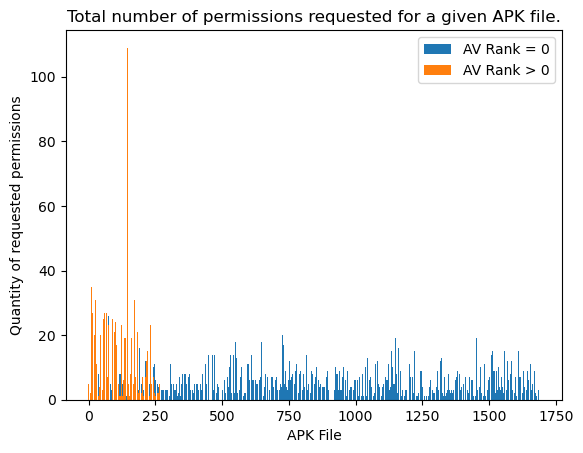

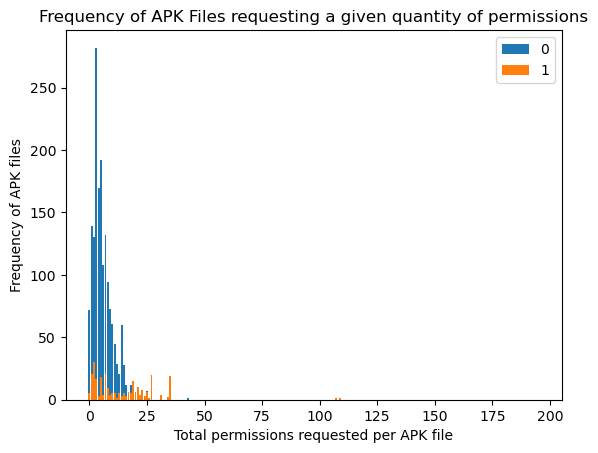

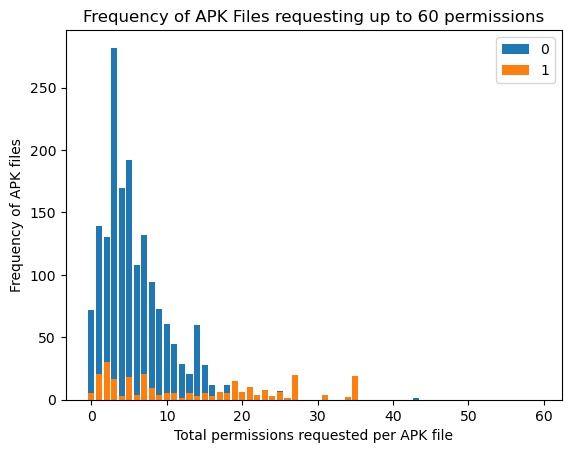

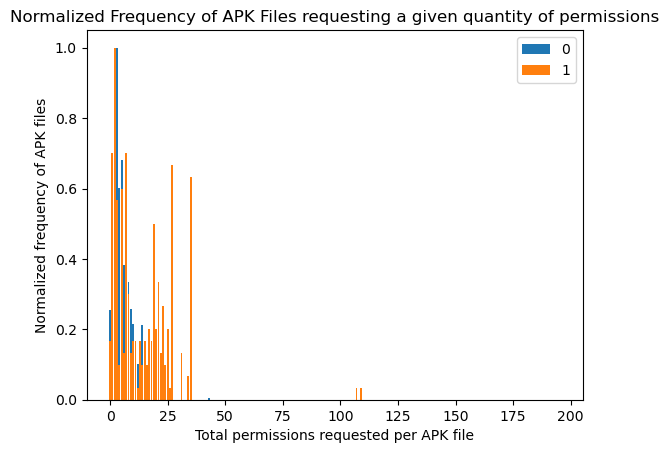

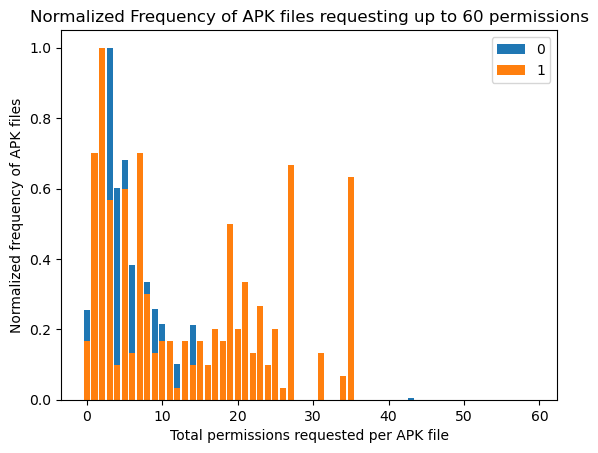

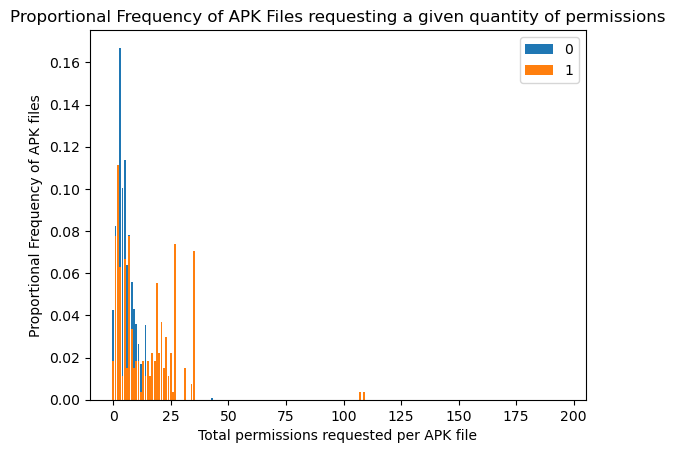

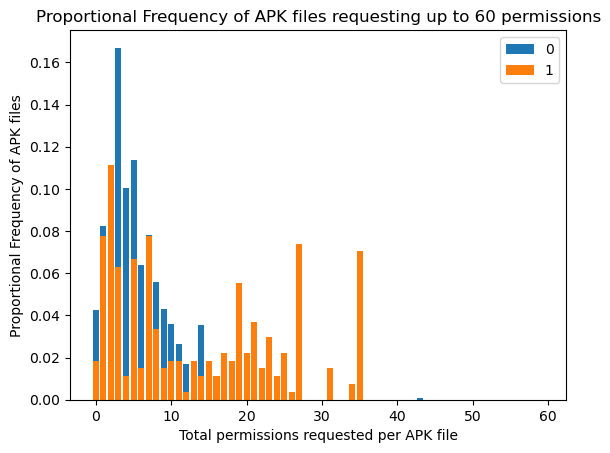

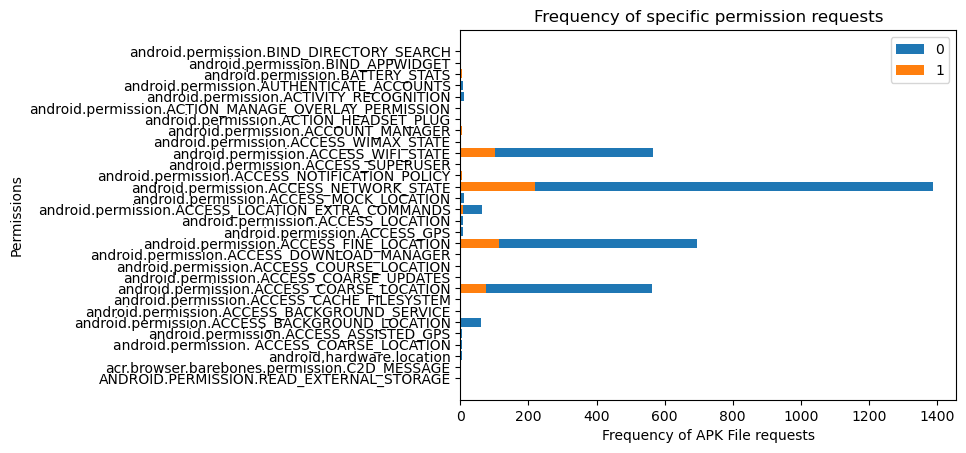

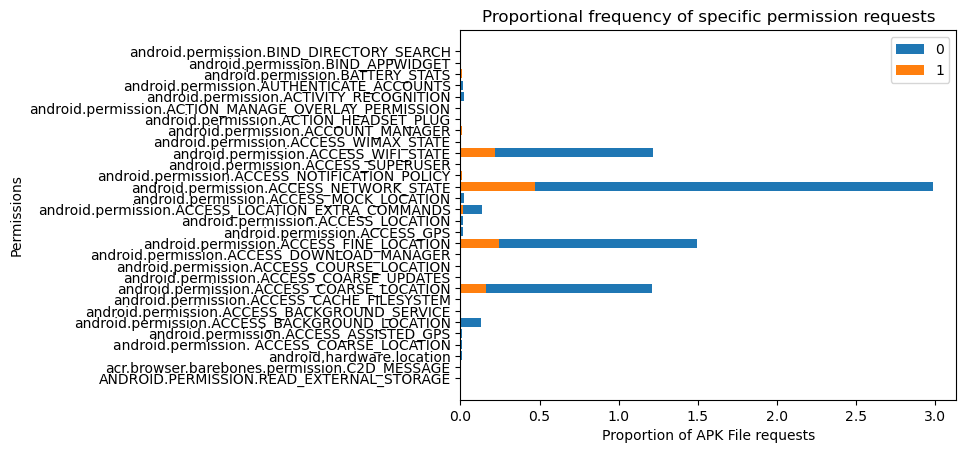

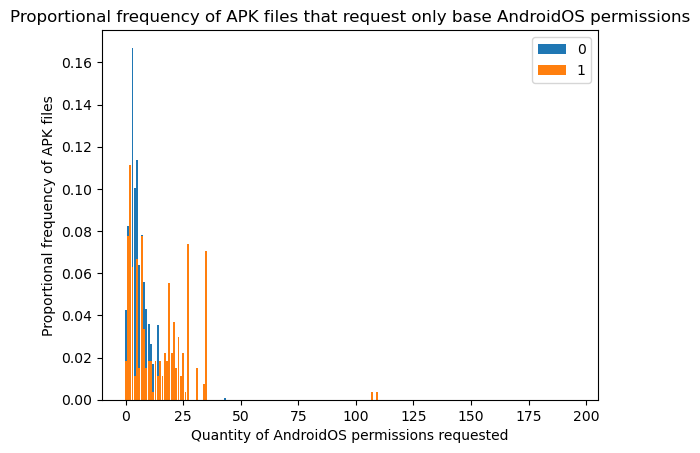

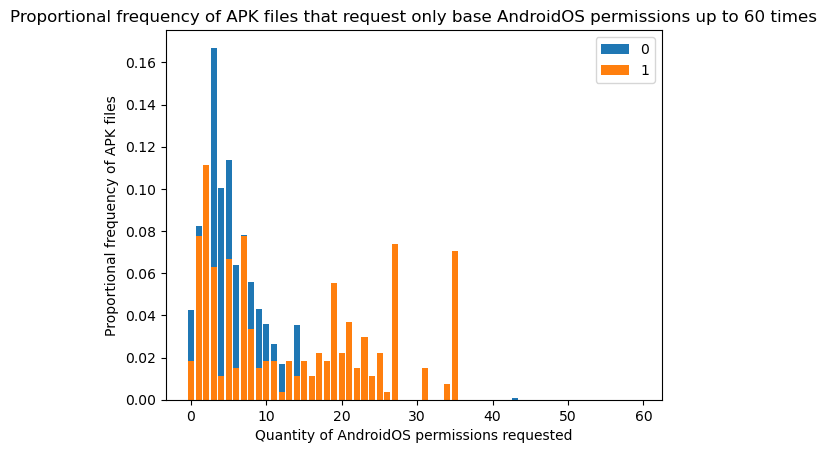

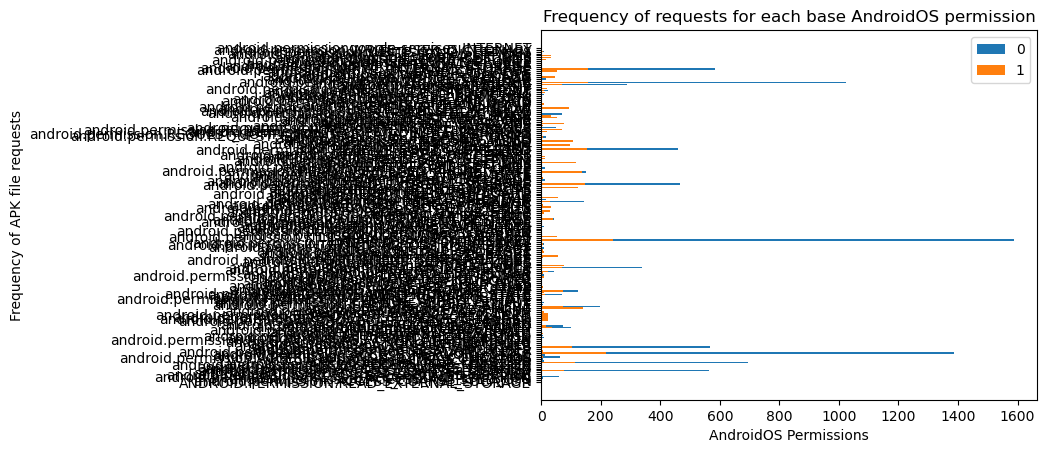

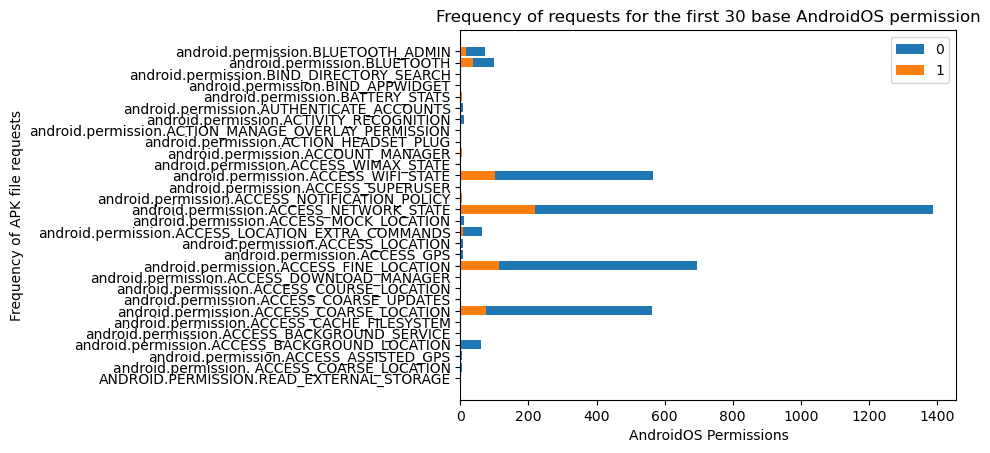

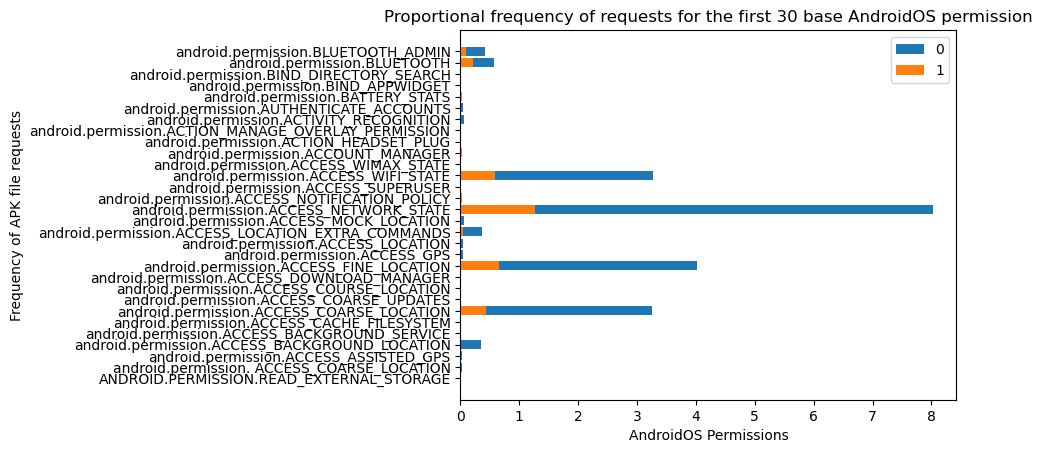

We analyzed 1959 APKs
Out of that, 270 were flagged as malicious. This is according to the dataset provided by Wang et al 2021.
Which means about 13.78% of all analyzed APKs are labeled as malicious.


In [2]:
# TODO:
# - percentage of apps that are malicious
# - percentage of apps that failed analysis
# - Std Dev, Std Err to compare my processed data with the data provided by COVIDMalware.pdf
#      - might be useful to includ metric of apks that failed analysis
#      - this can help confirm that what I did was right
#      - Check Stats 305 stuff to provide formulas and context for these values
# UPDATE the names of the graphs, they are hella misleading.

### Prepping our arrays
for i in range(len(perms)):
    permSpread.append(perms[i][2:]) # cleaning permission spread of AV Rank and total permission requests

    # Creating keys and permSpread arrays specifically for AndroidOS-based permissions
    arr = [] # subarray for our osPermSpread
    for ef in range(len(permKeys)):
        if permKeys[ef].lower().startswith("android.permission"):
            if permKeys[ef] not in osPermKeys: # keeps from multiplying immensely
                osPermKeys.append(permKeys[ef]) # Builds osPerms key array
            arr.append(perms[i][ef])
    osPermSpread.append(arr) # updating osPermSpread with our subarray

benignPerms = [0 for _ in range(len(permKeys))]
maliciousPerms = [0 for _ in range(len(permKeys))]
benignPerms_OS = [0 for _ in range(len(osPermKeys))]
maliciousPerms_OS = [0 for _ in range(len(osPermKeys))]

for i in range(len(apks)):
    if labels[i] > 0:
        maliciousSpread.append(permSpread[i]) # Sorting out malicious permission spreads
        maliciousSpread_OS.append(osPermSpread[i]) # ...and for OS specific permissions
        for j in range(len(permSpread[i])): 
            maliciousPerms[j] += permSpread[i][j] # building an array of ints representing malicious requests FE permission
        # restricting to only AndroidOS permissions...
        for j in range(len(osPermSpread[i])): 
            maliciousPerms_OS[j] += osPermSpread[i][j]
    else:
        benignSpread.append(permSpread[i]) # Sorting out benign permission spreads
        benignSpread_OS.append(osPermSpread[i]) # ...and for OS specific permissions
        for j in range(len(permSpread[i])): 
            benignPerms[j] += permSpread[i][j] # building an array of ints representing benign requests FE permission
        # restricting to only AndroidOS permissions...
        for j in range(len(osPermSpread[i])):
            benignPerms_OS[j] += osPermSpread[i][j]

# Collecting the sum of each array in malicious/benignSpread
benignSpread_sums = [sum(i) for i in benignSpread]
maliciousSpread_sums = [sum(i) for i in maliciousSpread]

# Building the x-array to display each APK's total permission request, distinguished by AV Rank > 0
x = [i for i in range(max(maliciousSpread_sums) + 1)] if maliciousSpread_sums > benignSpread_sums else [i for i in range(max(benignSpread_sums) + 1)]

# Building y-arrays to display each APK's total permission request, distinguished by AV Rank > 0
yBenign = [0 for _ in range(len(x))]
yMalicious = [0 for _ in range(len(x))]

for i in benignSpread_sums:
    yBenign[i] += 1

for i in maliciousSpread_sums:
    yMalicious[i] += 1

### Re-Doing yBenign and yMalicious for our OS specific permission spreads

benignSums = [sum(i) for i in benignSpread_OS]
maliciousSums = [sum(i) for i in maliciousSpread_OS]

# Resetting y arrays
yBenign = [0 for _ in range(len(x))]
yMalicious = [0 for _ in range(len(x))]

for i in benignSums:
    yBenign[i] += 1

for i in maliciousSums:
    yMalicious[i] += 1

### Plotting the total permissions requested by a given apk, organized based off an AV rank > 0

plt.bar([i for i in range(len(benignSums))], benignSums, label="AV Rank = 0")
plt.bar([i for i in range(len(maliciousSums))], maliciousSums, label="AV Rank > 0")
plt.xlabel("APK File")
plt.ylabel("Quantity of requested permissions")
plt.title("Total number of permissions requested for a given APK file.")
plt.legend()
plt.savefig("TotalPermissionsGraphed.png", dpi=300, bbox_inches = "tight")
plt.show()

### Plotting how many apps requested a given quantity of permissions

# Frequency
title = "Frequency of APK Files requesting a given quantity of permissions"
xLabel = "Total permissions requested per APK file"
yLabel = "Frequency of APK files"
visualize(x, [yBenign, yMalicious], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

# Frequency up to 60 permissions requested
title = "Frequency of APK Files requesting up to 60 permissions"
visualize(x[:60], [yBenign[:60], yMalicious[:60]], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

# ...Normalized
title = "Normalized Frequency of APK Files requesting a given quantity of permissions"
yLabel = "Normalized frequency of APK files"
visualize(x, [[i / max(yBenign) for i in yBenign], [i / max(yMalicious) for i in yMalicious]], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

# ...Normalized for up to 60 permissions
title = "Normalized Frequency of APK files requesting up to 60 permissions"
visualize(x[:60], [[i / max(yBenign) for i in yBenign[:60]], [i / max(yMalicious) for i in yMalicious[:60]]], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

# ...Proportioned based on the quantity of benign/malicious APKs respectively
title = "Proportional Frequency of APK Files requesting a given quantity of permissions"
yLabel = "Proportional Frequency of APK files"
visualize(x, [[i / len(benignSpread) for i in yBenign], [i / len(maliciousSpread) for i in yMalicious]], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

# Plotting proportional frequency of APK files that requested up to 60 permissions
title = "Proportional Frequency of APK files requesting up to 60 permissions"
visualize(x[:60], [[i / len(benignSpread) for i in yBenign[:60]], [i / len(maliciousSpread) for i in yMalicious[:60]]], title=title, save=True, x_Axs=xLabel, y_Axs=yLabel)

### Plotting the frequency of requests FE permission found during analysis

# Frequency of applications requesting a given permission
title = "Frequency of specific permission requests"
xLabel = "Frequency of APK File requests"
yLabel = "Permissions"
visualize(permKeys[2:32], [benignPerms[:30], maliciousPerms[:30]], title=title, x_Axs=xLabel, y_Axs=yLabel, save=True, flip=True)

# proportion of applications requesting a given permission
title = "Proportional frequency of specific permission requests"
xLabel = "Proportion of APK File requests"
visualize(
    permKeys[2:32],
    [[i / len(benignPerms) for i in benignPerms[:30]], 
        [i / len(maliciousPerms) for i in maliciousPerms[:30]]],
    title=title,
    x_Axs=xLabel,
    y_Axs=yLabel,
    save=True,
    flip=True)

### Re-Plotting for AndroidOS specific permission spreads

# resetting summation arrays
benignSums = [sum(i) for i in benignSpread_OS]
maliciousSums = [sum(i) for i in maliciousSpread_OS]

# Resetting y arrays
yBenign = [0 for _ in range(len(x))]
yMalicious = [0 for _ in range(len(x))]

for i in benignSums:
    yBenign[i] += 1

for i in maliciousSums:
    yMalicious[i] += 1

# Proportional frequency of APK files that requested only base AndroidOS permissions
title = "Proportional frequency of APK files that request only base AndroidOS permissions"
xLabel = "Quantity of AndroidOS permissions requested"
yLabel= "Proportional frequency of APK files"
visualize(x, [[i / len(benignSpread_OS) for i in yBenign], [i / len(maliciousSpread_OS) for i in yMalicious]], title=title, x_Axs=xLabel, y_Axs=yLabel, save=True)

# Proportional frequency of APK files that requested only base AndroidOS permissions up to 60 times
title = "Proportional frequency of APK files that request only base AndroidOS permissions up to 60 times"
visualize(x[:60], [[i / len(benignSpread_OS) for i in yBenign[:60]], [i / len(maliciousSpread_OS) for i in yMalicious[:60]]], title=title, x_Axs=xLabel, y_Axs=yLabel, save=True)

# Frequency of applications requesting base AndroidOS permissions
title = "Frequency of requests for each base AndroidOS permission"
xLabel = "AndroidOS Permissions"
yLabel = "Frequency of APK file requests"
visualize(osPermKeys, [benignPerms_OS, maliciousPerms_OS], title=title, x_Axs=xLabel, y_Axs=yLabel, flip=True, save=True)

# Frequency of applications requesting the first 30 base AndroidOS permissions
title = "Frequency of requests for the first 30 base AndroidOS permission"
visualize(osPermKeys[:30], [benignPerms_OS[:30], maliciousPerms_OS[:30]], title=title, x_Axs=xLabel, y_Axs=yLabel, flip=True, save=True)

# Proportion of applications requesting the first 30 base AndroidOS permissions
title = "Proportional frequency of requests for the first 30 base AndroidOS permission"
visualize(osPermKeys[:30], [[i / len(benignPerms_OS) for i in benignPerms_OS[:30]], [i / len(maliciousPerms_OS) for i in maliciousPerms_OS[:30]]], title=title, x_Axs=xLabel, y_Axs=yLabel, flip=True, save=True)

# How many APKs are malicious?
totalAPKs = len(apks)
totalBadAPKs = sum([1 if item > 0 else 0 for item in labels])
print(f"We analyzed {totalAPKs} APKs")
print(f"Out of that, {totalBadAPKs} were flagged as malicious. This is according to the dataset provided by Wang et al 2021.")
print(f"Which means about {((totalBadAPKs / totalAPKs) * 100):.2f}% of all analyzed APKs are labeled as malicious.")


Scikit Learn prep

In [ ]:
"""
### Package handling
"""
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC # importing the Classifier module specifically
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold

"""
### PARAMETER DECLARATION
- Modify this value if we wanna change how many iterations our models go through
    - this will change the size of masterTrain and masterTest arrays, hence changing how many times each model iterates through these folds
"""
FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2

### train_test_split()
# xTrain, xTest, yTrain, yTest = train_test_split(perms, labels, random_state=0, test_size=0.2)

"""
### Sklearn cross_val_score() module
- https://scikit-learn.org/stable/modules/cross_validation.html
- compare with the current manual split
    - Testing with DTrees --> Still yeilds 100% accuracy
"""
from sklearn.model_selection import cross_val_score, ShuffleSplit
ssplit = ShuffleSplit(n_splits=FOLDS, test_size=TEST_SIZE, random_state=RANDOM_STATE)
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, perms, labels, cv=ssplit)
print(scores.mean())
print(scores.std())

"""
### SMOTE
- This can be called prior to any sort of data separation
    - cross_val_score(), train_test_split(), KFold(), etc.
"""
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
perms_res, lables_res = smote.fit_resample(perms, labels)
ssplit = ShuffleSplit(n_splits=FOLDS, test_size=0.3, random_state=0)
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, perms, labels, cv=ssplit)
print(scores.mean())
print(scores.std())

"""
### Manual K-Fold Cross-Validation
- IMPROVE WITH SMOTE
- I'm pretty confident I'm not doing this right. Might have to go back to the drawing board with this.
"""
masterTrain = []
masterTest = []

kf = KFold(n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True) # declaring KFold object

# for i, (trainIndx, testIndx) in enumerate(kf.split(perms, labels)):
#     # print(trainIndx)
#     # print(testIndx)
    
#     xTrain = [perms[i] for i in trainIndx]
#     xTest = [perms[i] for i in testIndx]
#     yTrain = [labels[i] for i in trainIndx]
#     yTest = [labels[i] for i in testIndx]
    
#     masterTrain.append((xTrain, yTrain))
#     masterTest.append((xTest, yTest))

#     # print(f"iteration {i + 1}")
#     # print(f"Size of training features: {len(xTrain)}")
#     # print(f"Size of training labels: {len(yTrain)}")
#     # print(f"Size of testing features: {len(xTest)}")
#     # print(f"Size of testing labels: {len(yTest)}")
#     # print()

### verifying partition sizes prior to executing the next sections

# print(f"Total size of masterTrain: {len(masterTrain)}")
# print(f"Total size of masterTest: {len(masterTest)}")

# print(f"Size of an element in masterTrain: {len(masterTrain[0])}")
# print(f"Size of an element in masterTest: {len(masterTest[0])}")

# print(f"Type of element in masterTrain: {type(masterTrain[0])}")
# print(f"Type of element in masterTest: {type(masterTest[0])}")

# print(f"Size of features element in masterTrain tuple: {len(masterTrain[0][0])}")
# print(f"Size of labels element in masterTrain tuple: {len(masterTrain[0][1])}")

# print(f"Size of features element in masterTest tuple: {len(masterTest[0][0])}")
# print(f"Size of labels element in masterTest tuple: {len(masterTest[0][1])}")

"""
### SMOTE
"""
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
perms_res, lables_res = smote.fit_resample(perms, labels)
ssplit = ShuffleSplit(n_splits=FOLDS, test_size=0.3, random_state=0)
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, perms, labels, cv=ssplit)
print(scores.mean())
print(scores.std())


print("### CONSOLE: SciKit Learn preperation complete...")

Categorical Naive-Bayes

In [ ]:
"""
### NOTES:
- clfNB.predict() throws the following errors:
    - IndexError: index 1 is out of bounds for axis 1 with size 1
    - Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.
- I suspect this has to do with the xTrain and xTest sizes differing, but that defeats the purpose of unbalanced splits
    - applied in areas such as KF C-V (It throws the same error when I try it with that tactic as well...)
    - Training goes off without a hitch, which supports my theory
        - DTrees and SVM also work just fine...........
- Carlos Gonzalez gave me an idea to check the datatype being passed to the predict function, and see about the possibility of using a DF
"""

clfNB = CategoricalNB() # Calling Categorical Naive-Bayes classifier

# K-Fold Cross-Validation iteration
for i in range(FOLDS):
    xTrain = masterTrain[i][0]
    yTrain = masterTrain[i][1]

    xTest = masterTest[i][0]
    yTest = masterTest[i][1]

    print(f"testing features length: {len(xTest)}")
    print(f"datatype for testing features: {type(xTest)}")
    print(f"Testing features:\n{xTest}")

    """
    ### Training
    """
    t0 = time.time()
    clfNB.fit(xTrain, yTrain) # Train
    print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

    """
    ### Testing
    """
    t0 = time.time()
    prediction = clfNB.predict(xTest) # Predicting
    print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time
    
    """
    ### Metrics
    """
    print(f"Prediction accuracy: {(accuracy_score(prediction, yTest) * 100):.2f}%")


Support Vector Machines

In [ ]:
### PARAMETER DECLARATION
clf = SVC(kernel="poly", C=5, gamma='scale')

### SMOTE-ifying datasets
smote = SMOTE(random_state=42)
permSMOTE, labelSMOTE = smote.fit_resample(perms, labels)

"""
### Sklearn cross_val_score() module
- https://scikit-learn.org/stable/modules/cross_validation.html
- compare with the current manual split
    - Testing with DTrees --> Still yeilds 100% accuracy
"""
print("\n### CONSOLE: calling ShuffleSplit and cross_val_score()...")
from sklearn.model_selection import cross_val_score, ShuffleSplit
ssplit = ShuffleSplit(n_splits=FOLDS, test_size=TEST_SIZE, random_state=RANDOM_STATE)
scores = cross_val_score(clf, perms, labels, cv=ssplit)
print(ssplit)
print(scores.mean())
print(scores.std())

### Vanilla test-train split
print("### CONSOLE: Vanilla Datset split...")
xTrain, xTest, yTrain, yTest = train_test_split(perms, labels, random_state=0, test_size=0.2)

# Training
t0 = time.time()
clf.fit(xTrain, yTrain)
print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

# Testing
prediction = clf.predict(xTest)
print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time

# Metrics
confusion = confusion_matrix(yTest, prediction)
print(f"Prediction accuracy: {accuracy_score(prediction, yTest):.3f}%")
print(f"Confusion Matrix:\n{confusion}")
print("Malware")
print(f"Malware correctly identified (True Positives): {confusion[1][1]}")
print(f"Falsely classified as malicious (False Positives): {confusion[1][0]}")
print(f"Falsely classified as safe (False Negatives): {confusion[0][1]}") # --> MINIMIZE THIS VALUE
print(f"Recall: {(confusion[1][1] / sum(confusion[1])):.3f}")
print(f"Percision: {(confusion[1][1] / sum([confusion[r][1] for r in range(len(confusion))])):.3f}")
print()

"""
### Manual K-Fold Cross-Validation
- I'm pretty confident I'm not doing this right. Might have to go back to the drawing board with this.
"""
print("\n### CONSOLE: Practicing with manual K-Fold Cross-Validation")
kf = KFold(n_splits=FOLDS, random_state=RANDOM_STATE, shuffle=True) # declaring KFold object

# for i, (trainIndx, testIndx) in enumerate(kf.split(perms, labels)):
#     print(f"Iteration: {i + 1}")
#     # print(trainIndx)
#     # print(testIndx)
    
#     xTrain = [perms[i] for i in trainIndx]
#     xTest = [perms[i] for i in testIndx]
#     yTrain = [labels[i] for i in trainIndx]
#     yTest = [labels[i] for i in testIndx]

#     clf = SVC(kernel="poly", C=5, gamma='scale') # Calling within loop so that everything is reset

#     ### Training
#     t0 = time.time()
#     clf.fit(xTrain, yTrain)
#     print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

#     ### Testing
#     prediction = clf.predict(xTest)
#     print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time

#     ### Metrics
#     confusion = confusion_matrix(yTest, prediction)
#     print(f"Prediction accuracy: {accuracy_score(prediction, yTest):.3f}%")
#     print(f"Confusion Matrix:\n{confusion}")
#     print("Malware")
#     print(f"Malware correctly identified (True Positives): {confusion[1][1]}")
#     print(f"Falsely classified as malicious (False Positives): {confusion[1][0]}")
#     print(f"Falsely classified as safe (False Negatives): {confusion[0][1]}") # --> MINIMIZE THIS VALUE
#     print(f"Recall: {(confusion[1][1] / sum(confusion[1])):.3f}")
#     print(f"Percision: {(confusion[1][1] / sum([confusion[r][1] for r in range(len(confusion))])):.3f}")
#     print()

"""
### Now using SMOTE
"""
print("### CONSOLE: Ruinning the same models with SMOTE datsets...")
xTrain, xTest, yTrain, yTest = train_test_split(permSMOTE, labelSMOTE, random_state=0, test_size=0.2)

# Training
t0 = time.time()
clf.fit(xTrain, yTrain)
print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

# Testing
prediction = clf.predict(xTest)
print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time

# Metrics
confusion = confusion_matrix(yTest, prediction)
print(f"Prediction accuracy: {accuracy_score(prediction, yTest):.3f}%")
print(f"Confusion Matrix:\n{confusion}")
print("Malware")
print(f"Malware correctly identified (True Positives): {confusion[1][1]}")
print(f"Falsely classified as malicious (False Positives): {confusion[1][0]}")
print(f"Falsely classified as safe (False Negatives): {confusion[0][1]}") # --> MINIMIZE THIS VALUE
print(f"Recall: {(confusion[1][1] / sum(confusion[1])):.3f}")
print(f"Percision: {(confusion[1][1] / sum([confusion[r][1] for r in range(len(confusion))])):.3f}")
print()

print("\n### CONSOLE: calling ShuffleSplit and cross_val_score()...")
ssplit = ShuffleSplit(n_splits=FOLDS, test_size=TEST_SIZE, random_state=RANDOM_STATE)
scores = cross_val_score(clf, permSMOTE, labelSMOTE, cv=ssplit)
print(scores.mean())
print(scores.std())

Decision Trees

In [ ]:
"""
### NOTES
- K-Fold Cross-Validation returns an accuracy of 100%, which is quite sus my dood
    - tried with train_test_split(), same problem
- Manually partitioning the datasets prodouce a reasonable accuracy value...
- REALLY ODD MY GUY
"""

"""
### Manual partitioning
"""
# xTrain = []
# yTrain = []
# xTest = []
# yTest = []

# x = shuffle(perms, random_state=0)

# for i in range((2 * len(x)) // 3):
#     xTrain.append(x[i])
#     yTrain.append(labels[i])

# for i in range((2 * len(x)) // 3, len(x)):
#     xTest.append(x[i])
#     yTest.append(labels[i])

# print(len(xTrain))
# print(len(yTrain))
# print(len(xTest))
# print(len(yTest))

"""
### Train
"""
# t0 = time.time()
# dTree.fit(xTest, yTest)
# print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

"""
### Test
"""
# t0 = time.time()
# prediction = dTree.predict(xTest)
# print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time

"""
### Metrics
"""
# confusion = confusion_matrix(yTest, prediction)
# print(f"Prediction accuracy: {(accuracy_score(prediction, yTest) * 100):.2f}%")
# print(f"Confusion Matrix:\n{confusion}")
# print()

# print("0 = Benign")
# print(f"True Positives: {confusion[0][0]}")
# print(f"False Positives: {confusion[0][1]}") # --> MINIMIZE THIS VALUE
# print(f"False Negatives: {confusion[1][0]}")
# print(f"Total Recall B): {(confusion[0][0] / sum(confusion[0]))}")
# print(f"Percision: {(confusion[0][0] / sum([confusion[r][0] for r in range(len(confusion))])):.2f}")
# print()

# print("Maliciousness")
# print(f"True Positives: {confusion[1][1]}")
# print(f"False Positives: {confusion[1][0]}")
# print(f"False Negatives: {confusion[0][1]}") # --> MINIMIZE THIS VALUE
# print(f"Total Recall B): {(confusion[1][1] / sum(confusion[1]))}")
# print(f"Percision: {(confusion[1][1] / sum([confusion[r][1] for r in range(len(confusion))]))}")

### K-Fold Cross-Validation --> Prediction Accuracy and Recall both are 100%, so don't trust this RN
for i in range(FOLDS):

    print(f"### Iteration: {i + 1} ###")

    xTrain = masterTrain[i][0]
    yTrain = masterTrain[i][1]

    xTest = masterTest[i][0]
    yTest = masterTest[i][1]

    dTree = DecisionTreeClassifier() # a way to flush the DTree data b4 the next fold?

    """
    ### Train
    """
    t0 = time.time()
    dTree.fit(xTest, yTest) # want to retrain rather than improve itself
    print(f"Training time: {(time.time() - t0):.3f} s") # Mark training time

    """
    ### Test
    """
    t0 = time.time()
    prediction = dTree.predict(xTest)
    print(f"Prediction Time: {(time.time() - t0):.3f} s") # marking prediction time

    """
    ### Metrics
    """
    confusion = confusion_matrix(yTest, prediction)
    print(f"Prediction accuracy: {(accuracy_score(prediction, yTest) * 100):.2f}%")
    print(f"Confusion Matrix:\n{confusion}")
    print()

    print("Maliciousness")
    print(f"True Positives: {confusion[1][1]}")
    print(f"False Positives: {confusion[1][0]}")
    print(f"False Negatives: {confusion[0][1]}") # --> MINIMIZE THIS VALUE
    print(f"Total Recall B): {(confusion[1][1] / sum(confusion[1])):.2f}")
    print(f"Percision: {(confusion[1][1] / sum([confusion[r][1] for r in range(len(confusion))])):.2f}")
    print()

Neural Network Prep

In [ ]:
"""
### Site for Tensorflow reference: https://www.tensorflow.org/guide/distributed_training
"""
### Package handling
import tensorflow as tf
import keras
from keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
    Embedding,
    LSTM
)
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.models import Sequential

"""
### Can we use the GPU?
"""

if tf.test.gpu_device_name():
    print(f'GPU installed. Good Job!\nGPU Device: {tf.test.gpu_device_name()}')
else:
    print(" No GPU found that can run TF.")

"""
### Overridden callback class "timer" for catching epoch/total time
"""
class timer(keras.callbacks.callbacks):
    import time
    def __init__(self): # initalized callback
        super(timer, self).__init__() # remember inheritance from OOP

    # training methods
    def on_train_begin(self, logs=None):
        self.start_train=time.time()
    def on_train_end(self, logs=None):
        stop_train = time.time()
        train_duration = stop_train - start_train
        # Calculates metrics
        tr_hours = tr_duration // 3600
        tr_minutes = (tr_duration - (hours * 3600)) // 60
        tr_seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        # Generates message of string
        msg = f"Elapsed time: {str(tr_hours)}:{str(tr_minutes)}:{str(tr_seconds)}"
        print(msg)
    
    # batch training methods <-- might not need this
    def on_train_batch_begin(self, batch, logs=None):
        pass
    def on_train_batch_end(self, batch, logs=None):
        pass

    # epoch methods
    def on_epoch_begin(self, epoch, logs=None):
        self.start_epoch = time.time()
    def on_epoch_end(self, epoch, logs=None):
        stop_epoch = time.time()
        epoch_duration = stop_epoch - start_epoch
        msg = f"Epoch {epoch + 1} trained for {epoch_duration} seconds"
        print(msg)

    # prediction methods <-- this might be useful in the long run during CrossVal
    def on_predict_begin(self, logs=None):
        pass
    def on_predict_end(self, logs=None):
        pass

Visualizing performance

In [ ]:
"""
### Visualizing model performace
- I like the idea of visualizing our confusion matrix
  - use that to also visualize performance per K-fold iteration
- compare average values across all models
  - Train/Test: F1, accuracy, Recall, percision, time
- I can't remember the how else Dr Perez wants to compare data
"""
for val, data in history.history.items():
  plt.plot(data)
  plt.title(val)
  plt.show()
  print()